In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


In [3]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Paris_dfm.csv',
                   encoding='utf8')

In [4]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,review_count,reviews,room_type
0,0,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,5.0,93.0,1,3682,7,Entire home/apt
1,1,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,4.5,73.0,1,3682,31,Entire home/apt


In [5]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [7]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)



In [8]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + review_count + reviews + room_type -1'

In [9]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [11]:
X_train.shape, X_test.shape

((28834, 92), (12358, 92))

In [12]:
reg_scores = cross_val_score(LinearRegression(), X_train, y_train, cv= 10)
print reg_scores, np.mean(reg_scores)

[ 0.61302145  0.58757617  0.59608447  0.58851071  0.5950331   0.60839993
  0.60315013  0.58439218  0.59360505  0.57711357] 0.59468867618


In [13]:
linreg = LinearRegression().fit(X_train, y_train)

In [14]:
from sklearn.tree import DecisionTreeRegressor


In [15]:
predictions = cross_val_predict(linreg, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.579146755908


In [16]:
residuals = y_test - predictions
residuals

array([ 0.11613023,  0.68270757, -0.53312792, ...,  0.08122416,
       -0.16178895, -0.14363676])

In [17]:
np.mean(predictions)


4.5827437221792682

In [18]:
#linmod.coef_

In [19]:
print np.mean(y_train), np.mean(y_test)

4.58217177756 4.58283411993


In [20]:
Xn = StandardScaler().fit_transform(X)

In [21]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [23]:
# rf = RandomForestRegressor()

# rf_params = {
#     'n_estimators':[500],
#     'max_depth':[5,8,15,25,30,None],
#     'min_samples_split':[2,4,8,16,32,64,128],
#     'max_features':[None, 'sqrt', 'log2']
# }

# rf_gs = GridSearchCV(rf, rf_params, cv= 10, verbose=1, n_jobs=-1)
# rf_gs.fit(Xn_train, y_train)

In [24]:
# print rf_gs.best_params_
# rf_best = rf_gs.best_estimator_

# rf_scores = cross_val_score(rf_best, Xn_train, y_train, cv=10)
# print rf_scores
# print np.mean(rf_scores), np.std(rf_scores)

In [25]:
import time

In [26]:
start_time = time.time()

rf = RandomForestRegressor(max_features=None, min_samples_split=64, n_estimators=500, max_depth= None)

y_pred = rf.fit(Xn_train,y_train).predict(Xn_test)
r2_score = metrics.r2_score(y_test, y_pred)
print("r^2 on test data : %f" % r2_score)

print("--- %s seconds ---" % (time.time() - start_time))



r^2 on test data : 0.617580
--- 67.2035429478 seconds ---


In [27]:
#rf_best.feature_importances_

In [28]:
feature_imp = {}
for i, value in enumerate(rf.feature_importances_):
    feature_imp[i] = value

feature_imp = pd.DataFrame(feature_imp.items(), columns=['item_no','imp'])
feature_imp.head(2)

,item_no,imp
0,0,0.000047
1,1,0.000139


In [29]:
feature_name = {}
for i, value in enumerate(X_train.columns):
    feature_name[i] = value

feature_name = pd.DataFrame(feature_name.items(), columns=['item_no','name'])
feature_name.head(2)

,item_no,name
0,0,neighborhood[Amerique]
1,1,neighborhood[Archives]


In [30]:
feature_val = feature_name.merge(feature_imp, on='item_no')
feature_val.sort_values('imp',inplace=True,ascending=False,axis=0)

In [31]:
feature_val = feature_val.reset_index(drop=True)

In [32]:
feature_val.head(25)

,item_no,name,imp
0,83,bedrooms,0.477013
1,82,bathrooms,0.102023
2,84,dist_arprt,0.089361
3,80,room_type[T.Private room],0.088753
4,85,host_count,0.045392
5,81,room_type[T.Shared room],0.032195
6,90,review_count,0.032188
7,91,reviews,0.030700
8,87,minstay,0.029715
9,89,rest_count,0.017940


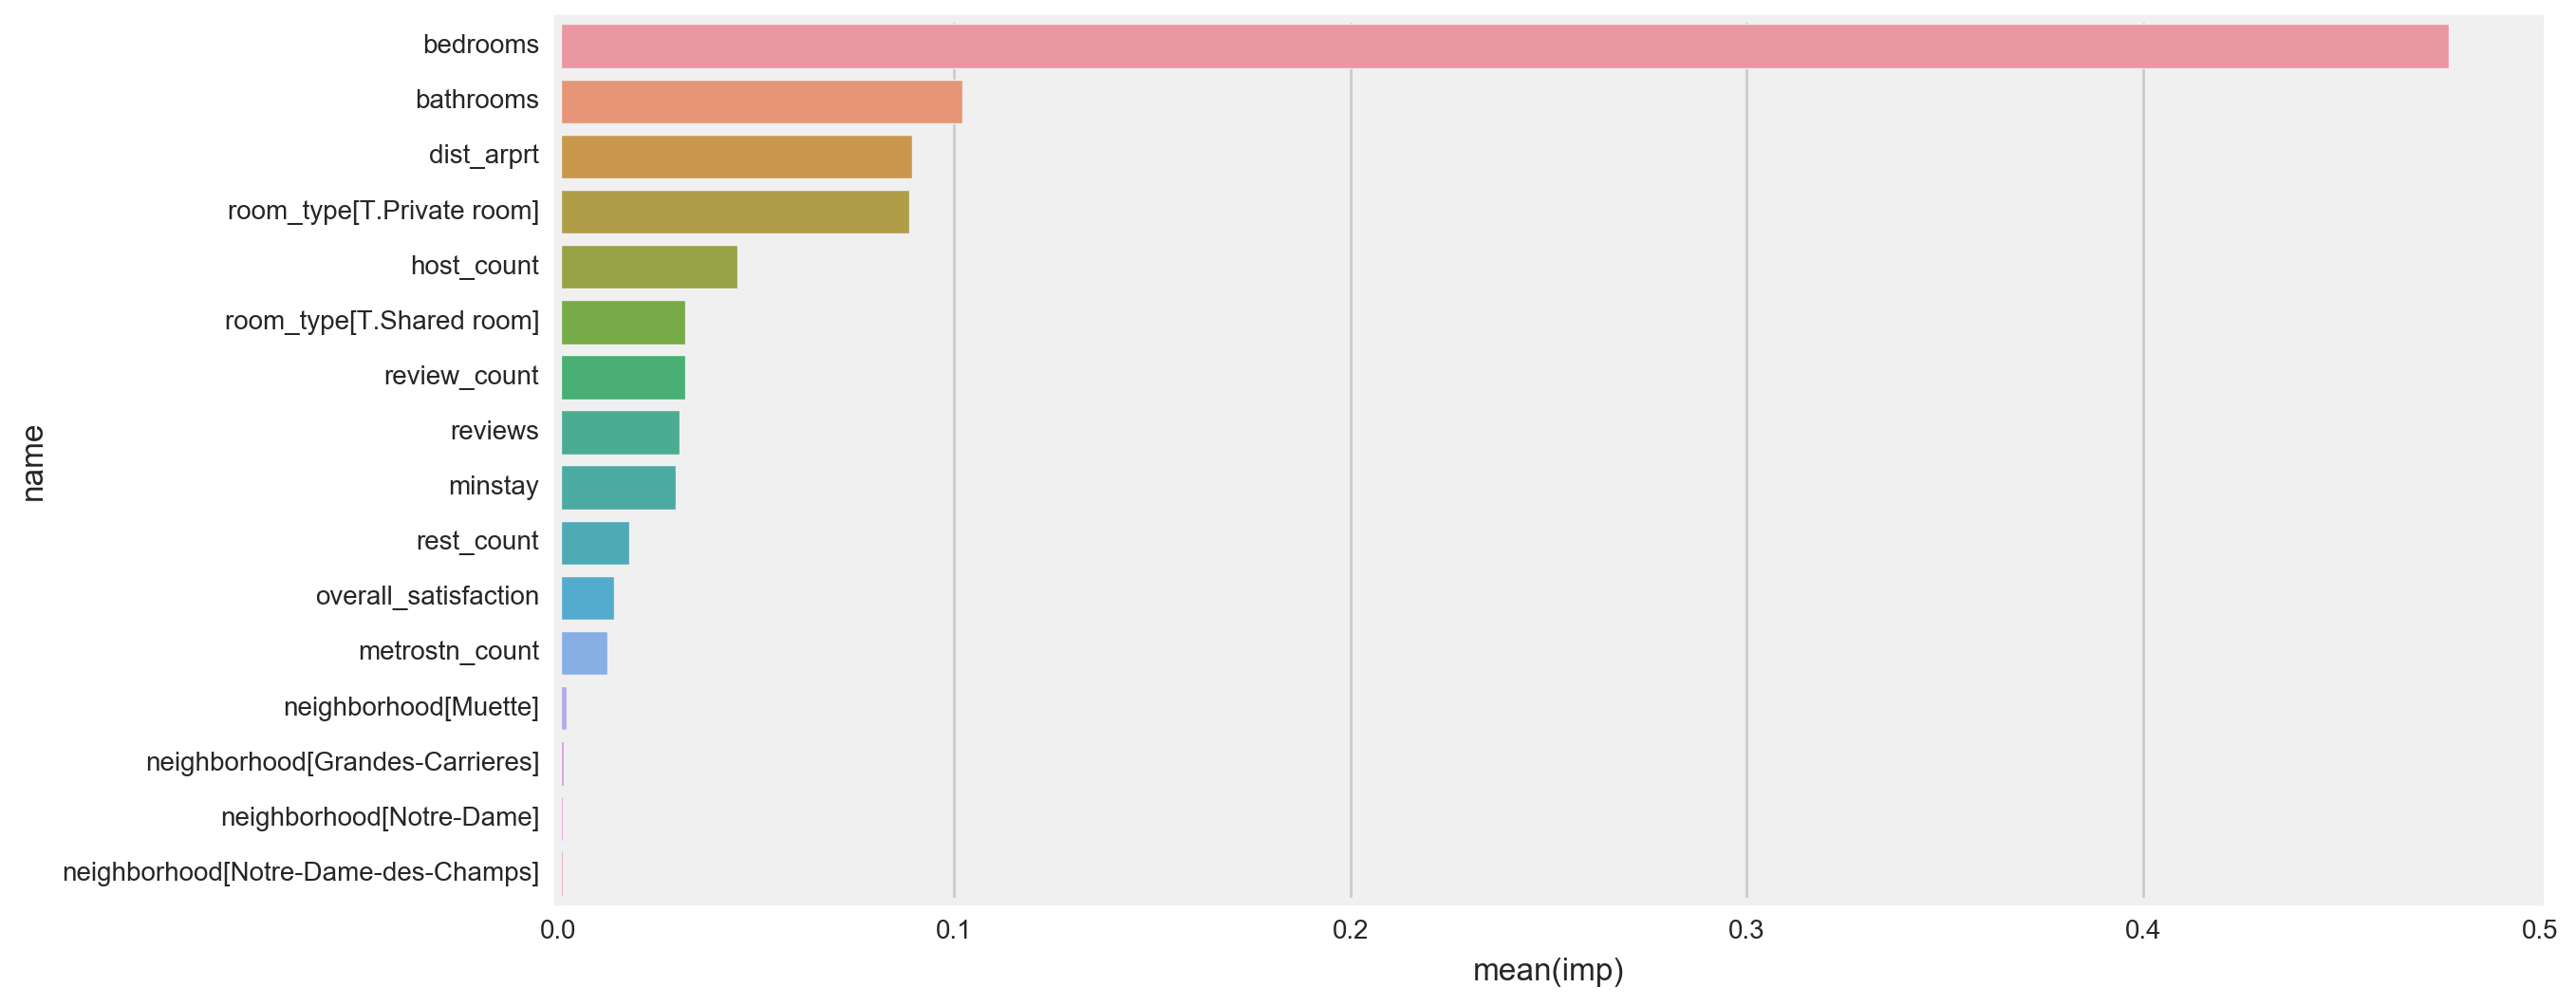

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
# ax.bar(range(1,feature_val.shape[0]-77), feature_val.imp, 
#        tick_label=feature_val.name)
# ax.set_xticklabels(feature_val.name, rotation=90)

sns.barplot(y = feature_val.loc[0:15,:].name, x = feature_val.loc[0:15,:].imp, data=feature_val.loc[0:15,:],orient=""
           )
plt.show()